In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/Project.toml`


In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using Random
using Test
using MeshCat
using MeshCatMechanisms
using RigidBodyDynamics
using StaticArrays

WebIO._IJuliaInit()

In [3]:
include("src/cost.jl")
include("src/linearize_dynamics.jl")
include("src/lqgame.jl")
include("src/solveilqgame.jl")
include("src/dynamics.jl");
# include("src/diff_robot.jl");

### Differential Drive continous kinematics



\begin{split}
\dot x &= v\cos(\theta)\\
\dot y &= v\sin(\theta)\\
\dot \theta &= \omega\\
\end{split}

Where $[\dot x, \dot y, \dot \theta]$ are the state, and $[v, \omega]$ are the control inputs.

In [4]:
# Setup the problem
dt = 0.1                    # Step size [s]
H = 10.0                    # Horizon [s]
k_steps = Int(H/dt)         # Number of steps (knot points)

# Initial and final states
# x₁, y₁, θ₁     

x₀= [5.0; 0.0; pi/2; 0.0; 0.0; 5.0; 0.0; 0.0]        # Initial state
xgoal = [5.0; 10.0; pi/2; 0.0; 10.0; 5.0; 0.0; 0.0]; # Final state

In [8]:
# Define cost matrices 

Q1 = sparse(zeros(8,8))     # State cost for agent 1
Q1[1:4,1:4] = 3.0*I(4)
Qn1 = Q1                    # Terminal cost for agent 1

Q2 = sparse(zeros(8,8))     # State cost for agent 2
Q2[5:8,5:8] = 1.0*I(4)
Qn2 = Q2                    # Terminal cost for agent 2

R11 = 1.0*I(2)              # Control cost for player 1
R22 = 1.0*I(2)              # Contorl cost for player 2
R12 = sparse(zeros(2,2))    # Control cost for player 1 associated with player 2's controls
R21 = sparse(zeros(2,2))    # Control cost for player 2 associated with player 1's controls

dmax = 2.0                  # Distance that both agents should keep between each other [m]
ρ = 500.0                   # Penalty factor for violating the distance constraint

# Input constraints
umax = [2.0, 2.0, 2.0, 2.0]            
umin = [-2.0,-2.0, -2.0, -2.0]

u1goal = [0.0, 0.0]
u2goal = [0.0, 0.0];

In [9]:
# # Define cost matrices 

# Q1 = sparse(zeros(6,6))     # State cost for agent 1
# Q1[1:3,1:3] = 3.0*I(3)
# Qn1 = Q1                    # Terminal cost for agent 1

# Q2 = sparse(zeros(6,6))     # State cost for agent 2
# Q2[4:6,4:6] = 1.0*I(3)
# Qn2 = Q2                    # Terminal cost for agent 2

# R11 = 1.0*I(2)              # Control cost for player 1
# R22 = 1.0*I(2)              # Contorl cost for player 2
# R12 = sparse(zeros(2,2))    # Control cost for player 1 associated with player 2's controls
# R21 = sparse(zeros(2,2))    # Control cost for player 2 associated with player 1's controls

# dmax = 2.0                  # Distance that both agents should keep between each other [m]
# ρ = 500.0                   # Penalty factor for violating the distance constraint

# # Input constraints
# umax = [2.0, 2.0, 2.0, 2.0]            
# umin = [-2.0,-2.0, -2.0, -2.0];
# x₀= [5.0; 0.0; pi/2; 0.0; 5.0; 0.0]        # Initial state
# xgoal = [5.0; 10.0; pi/2; 10.0; 5.0; 0.0]; # Final state

In [10]:
xₜ, uₜ = solveILQGame(diff_drive, costPointMass, x₀, xgoal, u1goal, u2goal, Q1, Q2, Qn1, Qn2, R11, R12, R21, R22, umin, umax, dmax, ρ, dt, H)

([5.0 0.0 … 0.0 0.0; 5.0000111876513 0.009999992959547893 … -0.014244959436981789 0.2; … ; 5.033157328756047 10.000046440876785 … 0.003784591100976605 -0.009849141568424478; 5.033157321646947 10.000102224173897 … 0.0037471199013907465 -0.009751625312905991], [2.0 -0.01678148187271611 2.0 -0.1424495943698179; 2.0 -0.0329049941217117 2.0 -0.15356479858867314; … ; -0.00016487673889870272 -3.766465902172707e-5 0.0009751625551848641 -0.0003747119958585846; 0.0 0.0 0.0 0.0])

In [11]:
xₜ[end,:]

8-element Vector{Float64}:
  5.033157321646947
 10.000102224173897
  1.5709218756607335
  0.0005495891387011718
 10.016129357851828
  4.939822656936435
  0.0037471199013907465
 -0.009751625312905991

┌ Info: Saved animation to /home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/assets/diff_drive.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/assets/diff_drive.gif")
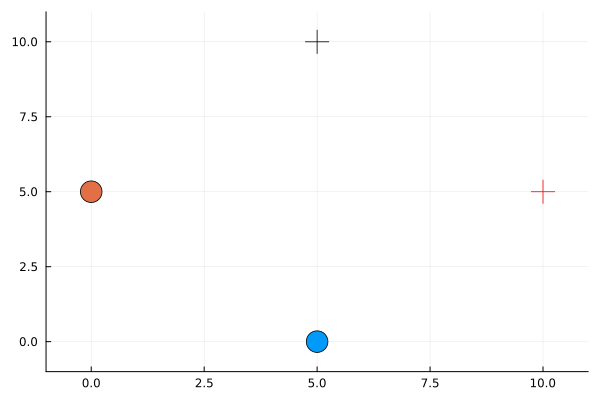

In [12]:
# Animation of the solution. GIF is saved in the assets folder.

anim = @animate for t in 1:k_steps
    scatter([xₜ[t, :][1]], [xₜ[t, :][2]], m = (:circle, 12),
    xlims = (-1, 11), 
    ylims = (-1, 11), 
    legend = false)
    scatter!([xₜ[t, :][5]], [xₜ[t, :][6]], m = (:circle, 12))
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :black))
    plot!([xgoal[5]], [xgoal[6]], m = (:cross, 12, :red))
end every 1;
gif(anim, "assets/diff_drive.gif")

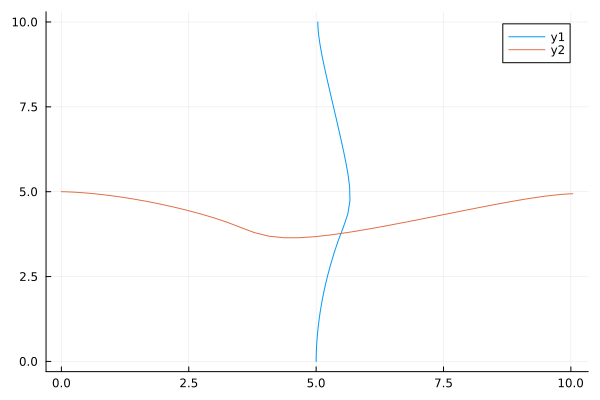

In [13]:
plot(xₜ[:, 1], xₜ[:, 2])
plot!(xₜ[:, 5], xₜ[:, 6])


In [14]:
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/ahmed/.julia/packages/MeshCat/oC0sL/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [15]:
const URDFPATH = joinpath(@__DIR__, "turtlebots","description","turtlebot3_burger.urdf")

"/home/ahmed/Desktop/repos/courses/seattle/CSE579-main/LQ_Game_Solver/turtlebots/description/turtlebot3_burger.urdf"

In [16]:
delete!(vis)
robot = parse_urdf(URDFPATH, floating = false)
mvis = MechanismVisualizer(robot, URDFVisuals(URDFPATH), vis)
set_configuration!(mvis, [0.0, 0.0])
robot

Spanning tree:
Vertex: world (root)
  Vertex: wheel_left_link, Edge: wheel_left_joint
  Vertex: wheel_right_link, Edge: wheel_right_joint
No non-tree joints.

In [ ]:
body = findbody(robot, "wheel_left_link")

RigidBody: "wheel_left_link"

In [ ]:
state = MechanismState(robot, randn(2), randn(2))
t, q, v = simulate(state, 5.0);

In [ ]:
anim = MeshCat.Animation(mvis, t, q)
setanimation!(mvis, anim)